In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Somers' D

##### This code is used to calculate Somers' D for binary dependent variables, which is defined as

<img src='PNG/SomersD.PNG'>

 where
- Nc is the number of "concordant" pair if the obs with target variable 1 has higher score compared with obs with target variable 0; 
- Nd is the number of "disconcordant" pair if the obs with target variable 1 has lower score compared with obs with target variable 0; 
- Nt is the number of "tie" pair if obs with target variable 1 has equal score with obs with target variable 0.

Based on the definition, it is computationally expensive to calculate Somers' D. Mathematically, Somers' D is equal to Gini coefficient. Calculate Gini coefficient is much more easier as below:

<img src='PNG/Gini.PNG'>

where
- cum% of event i = (num of obs with target = 1 from bin 1 to bin i)/(total num of obs with target = 1)
- cum% of noevent i = (num of obs with target = 0 from bin 1 to bin i)/(total num of obs with target = 0)

In [2]:
def SomersD(df, score, target, num_buckets):

# Parameter Instruction:
    # df: Pandas DataFrame, which includes one model score column and one true target column
    # score: model score column
    # target: true target column
    # num_buckets: number of buckets

    
    # Step1: Threshold of each bucket
    base = [0]
    for i in range(1, num_buckets):
        base.append(np.percentile(df[score], (100/num_buckets)*i))
    base.append(i)

    
    # Step2: Cum # of events vs. no-events in each bucket
    event = []
    noevent = []
    for i in range(0, num_buckets + 1):
        event_i = df[df[score] <= base[i]][target].sum()
        noevent_i = df[df[score] <= base[i]][target].count() - df[df[score] <= base[i]][target].sum()
        event.append(event_i)
        noevent.append(noevent_i)
    
    df_temp = pd.DataFrame([noevent, event]).T

    
    # Step3: Cum % of events vs. no-events in each bucket
    df_temp['cum_event'] = df_temp[1]/event[num_buckets]
    df_temp['cum_noevent'] = df_temp[0]/noevent[num_buckets]
    total = 0
    cum_event_r = [0]
    for i in range(1, num_buckets + 1):
        # Somers'D
        total += (df_temp['cum_event'][i] + df_temp['cum_event'][i-1])*(df_temp['cum_noevent'][i] - df_temp['cum_noevent'][i-1])

        # Bucket bad% 
        df_temp['cum_event0'] = df_temp['cum_event'].shift(1)
        df_temp = df_temp.fillna(0)
        df_temp['event'] = df_temp['cum_event'] - df_temp['cum_event0']
        df_temp = df_temp.drop(columns = ['cum_event0'])

        # Cumulative bad% Coverage
        df_temp0 = pd.DataFrame(df_temp['event'].iloc[::-1]).reset_index()
        df_temp0.drop(columns = ['index'], inplace = True)
        df_temp0.rename(columns={"event": "event_r"}, inplace = True)
        df_final = df_temp.merge(df_temp0, left_index=True, right_index=True)
        df_final['event_r'] = df_final['event_r'].shift(1)
        df_final = df_final.fillna(0)
        cum_event_r_i = sum(df_final['event_r'][0:i+1])
        cum_event_r.append(cum_event_r_i)

    df_final['cum_event_r'] = pd.DataFrame(cum_event_r)

    
    # Step4: Calculate Somers'D and plot
    SomersD = 1- total
        # Cumulative bad% Coverage plot
    f, ax = plt.subplots(figsize=(6, 6))
    plt.plot(range(0, num_buckets+1), df_final['cum_event_r'])
    plt.ylabel("Cumulative Bad%")
    plt.xlabel("Bucket")
    plt.title("Somers' D is " + str(SomersD))

    ax.set(xlim=(0, num_buckets), ylim=(0, 1))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    
        # Bucket bad% plot
    plt.figure(figsize=(6, 6))
    plt.subplot()
    plt.plot(range(0, num_buckets+1), df_temp['event'])
    plt.title("Somers' D is " + str(SomersD))    

##### Example

In [3]:
df = pd.read_csv("DATA/SomersD.csv")
df['target'] = df['target'].map(lambda x: int(x))
df.tail()

,score,target
995,0.0822,1
996,0.0339,0
997,0.0405,0
998,0.0911,1
999,0.0707,1


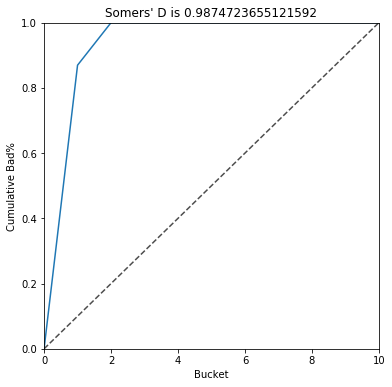

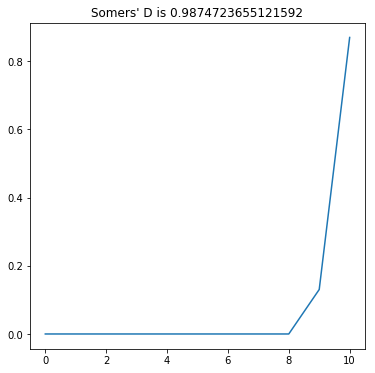

In [4]:
SomersD(num_buckets = 10
        ,df = df
        ,score = 'score'
        ,target = 'target')